In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.integrate import nquad, quad
import pandas as pd
from scipy.interpolate import interp1d
from ipywidgets import interactive, FloatSlider
from IPython.display import display

# Bipolar Seesaw

In the following, the temperature of Greenland is simulated by a step function switching between a cold and a worm state. The equation
$\begin{equation}
T_S(t) = - \frac{1}{\tau} \int_0^t \left[ T_N(t-t')e^{-t'/\tau}\right]dt'+T_S(0)e^{-t'/\tau}
\end{equation}$
is used to calculate the Temperature of Antarctica ($T_S$). $\tau$ (tau) can be modified to change the time scale of the heat reservoir which convolves northern time signals.
To make the result more realistic, noise can be added to the data. $\alpha$ is a parameter for a gaussian white noise, which can be modified to a red noise by adding $\beta$. 

In [2]:
width_of_upper_step_min, width_of_upper_step_max = 45, 55  
width_of_lower_step_min, width_of_lower_step_max = 15, 25 

def X(num_of_steps, tau, alpha, beta):
    fig, ax = plt.subplots(1,1, figsize=(10,5))

    step = np.array([])
    num_of_steps = int(num_of_steps)
    for i in range(num_of_steps):
        up   = np.full(random.randint(width_of_lower_step_min, width_of_lower_step_max), np.random.uniform(0.7, 1))
        down = np.full(random.randint(width_of_upper_step_min, width_of_upper_step_max), np.random.uniform(0, -0.2))
        step = np.concatenate((step,down))
        step = np.concatenate((step,up))
    t = np.arange(len(step))
    step = (step - np.mean(step)) / np.std(step)

    S0 = 2.0  
    N0 = 2.0  
    dt = 0.2

    num_steps = len(step)

    time = np.arange(0, num_steps * dt, dt)
    S = np.zeros(num_steps)
    N = np.zeros(num_steps)

    S[0] = S0
    N[0] = N0

    for i in range(1, num_steps):
        S[i] = S[i-1] - (dt/tau) * (N[i-1] + S[i-1])
        N[i] = step[i]

    S = (S - np.mean(S)) / np.std(S)

    def add_red_noise(data, alpha, seed=1):
        rng = np.random.default_rng(seed)
        noise = rng.normal(0, beta, len(data))
        fft = np.fft.fft(noise)
        frequencies = np.fft.fftfreq(len(data))
        filter = np.power(np.abs(frequencies) + 1e-10, -alpha / 2)
        filtered_fft = fft * filter
        filtered_noise = np.real(np.fft.ifft(filtered_fft))
        return data + filtered_noise

    plt.plot(-time, step, label = 'Simulated Greenland')
    plt.plot(-time, S, label='Calculated Antarctica')

    Tsp = add_red_noise(S, alpha)
    plt.plot(-time, Tsp, c = "tab:red", alpha = 0.7, label = 'Calculated Antarctica with noise')

    plt.xlabel('Time')
    plt.ylabel('Temperature (arb. values)')
    plt.title('Temperature of Antarctica Calculated from \n Simulated Temperature of Greenland')
    plt.legend()
    
#interact(X, num_of_steps=(1,10,1), tau=(0.2,20,0.1), alpha=(0,0.2,0.05), beta=(0,0.2,0.05))

num_of_steps_slider = FloatSlider(value=5, min=1, max=10, step=1, description='# of Steps')
tau_slider = FloatSlider(value=5, min=0.2, max=20, step=.1, description=r'$\tau$')
alpha_slider = FloatSlider(value=0.1, min=0, max=0.2, step=0.05, description=r'$\alpha$')
beta_slider = FloatSlider(value=0.1, min=0, max=0.2, step=0.05, description=r'$\beta$')
interactive_plot = interactive(X, num_of_steps=num_of_steps_slider, tau = tau_slider, alpha = alpha_slider, beta = beta_slider)

display(interactive_plot)
plt.show()

interactive(children=(FloatSlider(value=5.0, description='# of Steps', max=10.0, min=1.0, step=1.0), FloatSlid…

Now, real data for Greenland (NGRIP: North GReenland Ice Coring Project) and Antarctica (WDC: Wais Divide Core) are introduced. In the first figure, the Greenland time series is shown. In the second figure, the true Antarctic time series is shown together with the calculation of the Antarctic time series from the Greenland time series using the seesaw model. For which value of $\tau$ (tau) is the calculation closest to the real time series? Which parts are well simulated, where are differences?

In [3]:
def X(tau):
    fig, ax = plt.subplots(2,1, figsize=(10,5))

    dT = 0.02
    t = np.arange(-60, -20, dT)
    t_ = [x for x in t]

    def moving_midpoint(data, window_size):
        midpoint_values = []

        for i in range(len(data) - window_size + 1):
            window_data = data[i:i + window_size]

            min_value = np.min(window_data)
            max_value = np.max(window_data)

            midpoint = (min_value + max_value) / 2
            midpoint_values.append(midpoint)

        return np.array(midpoint_values)

    def subtract_moving(data, window_size):
        movemid = data[int(window_size/2):-int(window_size/2-1)]-moving_midpoint(data, window_size)
        return np.pad(movemid, (int(window_size/2), int(window_size/2-1)), mode='constant', constant_values=0)

    def data_cut(data, start, end):

        start_index = next((i for i, value in enumerate(t) if value >= start), None)
        end_index = next((i for i, value in reversed(list(enumerate(t))) if value <= end), None)

        if start_index is not None and end_index is not None:
            t_ = t[start_index:end_index + 1]
            data_ = data[start_index:end_index + 1]
            return t_, data_
        else:
            return None, None

    path = "C:/Users/morit/documents/Masterarbeit/data/"

    df = pd.read_csv(path + "ngrip_20yr.txt", sep = "\t", header = 50, engine = "python")
    df_ = pd.DataFrame(df['Age'])
    df_['Ca2+'] = df['[Ca2+] NGRIP2']
    df_['Ca2+'] = df_['Ca2+'].str.replace(',', '.')
    df_ = df_.drop(df_.index[0])
    df_['Age']=pd.to_numeric(df_['Age'])
    df_["Age"] = -df_["Age"]/1000
    df_["Age"] = df_["Age"]-0.05
    df_["Age"] = df_["Age"]-0.01
    df_["Age"] = df_["Age"]*1.0063
    df_cleaned = df_.dropna(subset=['Ca2+']) 
    max_val, min_val = np.round(np.max(df_["Age"]),3), np.round(np.min(df_["Age"]),3)
    max_difference = np.round(df_['Age'][df_["Age"]>t_[0]].diff().abs().max(),3)
    cal = interp1d(df_cleaned['Age'].values, df_cleaned['Ca2+'].values, kind="linear")(t_)
    cal = -np.log(cal)
    cal_= cal
    cal = (cal - np.mean(cal)) / np.std(cal)
    cal = subtract_moving(cal, 500)
    cal = data_cut(cal, -55, -25)[1]
    ax[0].plot(data_cut(cal, -55, -25)[0],cal, label = r"NGRIP -log$_{10}$Ca$^{2+}$")

    ### WD d18O ###
    WD_age = pd.read_csv(path + "WD2014_506modAKZ291b_v4.txt", sep = "\t", header = 12, engine = "python")
    df = pd.read_csv(path + "WAIS_project_members_Source_Data.txt", sep = "\t", header = 44, engine = "python")
    df1 = df[["Depths Top (m)", "Depths Bottom (m)"]].mean(axis=1).to_frame()
    df1.rename(columns={0: "Depth"}, inplace=True)
    df2 = df[["WD2014 Age Top (ka1950.0)", "WD2014 Age Bottom (ka1950.0)"]].mean(axis=1).to_frame()
    df2.rename(columns={0: "WD2014 Age"}, inplace=True)
    df3 = df["Isotope Data d18O (per mil)"]
    df_ = pd.concat([df1, df2, df3], axis=1)
    WD_age["Ice age (years BP)"] = -WD_age["Ice age (years BP)"]/1000
    df_["WD2014 Age"] = interp1d(WD_age["Depth (m)"], WD_age["Ice age (years BP)"], kind='linear', fill_value='extrapolate')(df_["Depth"])
    max_val, min_val = np.round(np.max(df_["WD2014 Age"]),3), np.round(np.min(df_["WD2014 Age"]),3)
    max_difference = np.round(df_["WD2014 Age"][df_["WD2014 Age"]>t_[0]].diff().abs().max(),3)
    wd = interp1d(df_["WD2014 Age"], df_["Isotope Data d18O (per mil)"], kind="linear")(t_)
    wd_= wd
    wd = (wd - np.mean(wd)) / np.std(wd)
    wd = data_cut(wd, -55, -25)[1]
    plt.plot(data_cut(wd, -55, -25)[0],wd, c = "tab:orange", label = r"WDC")

    step = cal

    S0 = 2.0  
    N0 = 0.0  
    dt = 0.2

    num_steps = len(step)

    time = np.arange(0, num_steps * dt, dt)
    S = np.zeros(num_steps)
    N = np.zeros(num_steps)

    S[0] = S0
    N[0] = N0

    for i in range(1, num_steps):
        S[i] = S[i-1] - (dt/tau) * (N[i-1] + S[i-1])
        N[i] = step[i]

    S = (S - np.mean(S)) / np.std(S)

    plt.plot(data_cut(cal, -55, -25)[0], S, c = "tab:red", label= r'Calculated from Greenland, $\tau$ = ' + str(tau))

    plt.ylabel('Temperature (arb. values)')
    plt.xlabel('Time (ky BP)')
    ax[0].set_ylabel('Temperature (arb. values)')
    ax[0].set_title('Greenland time series')
    ax[1].set_title('Antarctica time series')
    plt.tight_layout()
    plt.legend()
    
tau_slider = FloatSlider(value=0.2, min=0.2, max=15, step=.5, description=r'$\tau$')
interactive_plot = interactive(X, tau = tau_slider)

display(interactive_plot)
plt.show()

interactive(children=(FloatSlider(value=0.2, description='$\\tau$', max=15.0, min=0.2, step=0.5), Output()), _…

# Band-pass Filter

All frequencies between the lower and higher frequencies are passed by the filter. Can you find out, what is the frequeny of the time series by shifting those values? What is the influence of the order of the filter on the outcome?

In [4]:
from scipy.signal import butter, filtfilt

def generate_sample_data():
    np.random.seed(42)
    t = np.linspace(0, 10, 1000, endpoint=False) 
    signal = np.sin(2 * np.pi * 1 * t) + 0.5 * np.random.normal(size=len(t))  
    return t, signal


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

def plot_filtered_data(ax, time, data, lowcut, highcut, order):
    fs = 1 / (time[1] - time[0])
    filtered_data = butter_bandpass_filter(data, lowcut, highcut, fs, order)
    ax.plot(time, filtered_data, 'tab:red', label = "Band-pass Filtered")

time, data = generate_sample_data()

def X(lowcut, highcut, order):
    fig, ax = plt.subplots(1,1, figsize=(10,5))
    ax.plot(time, data, "tab:blue", label='Time Series', alpha=0.8)
    plot_filtered_data(ax, time, data, lowcut, highcut, order)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend(loc = 1)


lowcut_slider = FloatSlider(value=0.5, min=0.1, max=1.9, step=0.1, description='Lower freq.')
highcut_slider = FloatSlider(value=2.5, min=2, max=10, step=0.1, description='Upper freq.')
order_slider = FloatSlider(value=3, min=1, max=4, step=1, description='Order')
interactive_plot = interactive(X, lowcut=lowcut_slider, highcut = highcut_slider, order = order_slider)

display(interactive_plot)


plt.show()

interactive(children=(FloatSlider(value=0.5, description='Lower freq.', max=1.9, min=0.1), FloatSlider(value=2…

In [5]:
from sklearn.decomposition import PCA
from ipywidgets import interactive, FloatSlider

t = np.linspace(0, 10, 1000)

def function(p=4, offset=0):
    return np.cos(p * t + offset)

def PCA_(data1, data2, comp, ref_direction=None):
    combined_data = np.vstack((data1, data2)).T
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(combined_data)
    
    # Check if reference direction is provided and flip PCs if needed
    if ref_direction is not None:
        if pca.components_[0][0] * ref_direction[0][0] < 0:
            pca_result[:, 0] *= -1
        if pca.components_[1][1] * ref_direction[1][1] < 0:
            pca_result[:, 1] *= -1
   
    return [pca_result[:, comp], pca.components_, str(np.round(pca.explained_variance_ratio_*100,2)[comp]) + " %"]

ref_direction = PCA_(function(1, offset=0), function(1, offset=0), None, None)[1]  

def plot(p, offset):
    fig, ax = plt.subplots(2, 2, figsize=(10, 4))
    
    data1 = function(p, offset=0)
    data2 = function(p, offset)

    ax[0][0].plot(t, data1, label="y1")
    ax[0][0].plot(t, data2, label="y2")
    
    # Pass reference direction to PCA_ function
    pca_result1 = PCA_(data1, data2, 0, ref_direction)
    pca_result2 = PCA_(data1, data2, 1, ref_direction)

    ax[0][1].plot(t, pca_result1[0], "k", label= "PC1 (" + str(pca_result1[2]) + ')')
    ax[0][1].plot(t, pca_result2[0], "k--", label= "PC2 (" + str(pca_result2[2]) + ')')
    
    ax[1][0].plot(data1,data2, "k")
    ax[1][1].plot(pca_result1[0],pca_result2[0], "k")
    
    ax[1][0].set_ylim(-1.5,1.5)
    ax[1][1].set_ylim(-1.5,1.5)
    ax[1][0].set_xlim(-1.5,1.5)
    ax[1][1].set_xlim(-1.5,1.5)
    
    ax[0][0].grid()
    ax[0][1].grid()
    
    ax[1][0].set_ylabel('y2')
    ax[1][0].set_xlabel('y1')
    
    ax[1][1].set_ylabel('PC2')
    ax[1][1].set_xlabel('PC1')

    ax[0][0].legend(loc=1)
    ax[0][1].legend(loc=1)
    ax[0][1].set_ylim(-1.5, 1.5)

p_slider = FloatSlider(value=0.7, min=0.5, max=2, step=0.2, description='P: ')
offset_slider = FloatSlider(value=np.pi/2, min=0, max=2*np.pi, step=np.pi/10, description='Offset: ')
interactive_plot = interactive(plot, p=p_slider, offset=offset_slider)

display(interactive_plot)

plt.show()

interactive(children=(FloatSlider(value=0.7, description='P: ', max=2.0, min=0.5, step=0.2), FloatSlider(value…

# Potential Analysis

In [6]:
def ukf_1dim(para, h):
    
    """
    Performs ukf (1-dimension)

    Parameters:
    - para (list): parameters for the potential
    - h (float): stepsize of ukf

    Returns:
    float: log likelihood
    """
    
    n = len(data)
    h = h #0.001   
    R = para[4]**2 
    Q = h*para[5]**2 
    transient = 50 
    L = int(dT/h)

    x_pre = np.zeros(n)
    p_pre = np.zeros(n)
    
    x_pre[0] = data[0]
    
    if p_pre[0] == 0:
        p_pre[0] = R
    
    loc_lnlike = np.zeros(n)
    
    for k in range(1,n):
        
        x_pre[k] = x_pre[k-1]
        p_pre[k] = p_pre[k-1]
        
        for l in range(1, L+1): 
            A = np.sqrt(p_pre[k])
            sp = [x_pre[k]+A,x_pre[k]-A]
            sp = [x - h*(4*para[3]*x**3 + 3*para[2]*x**2 + 2*para[1]*x + para[0]) for x in sp]
            x_pre[k] = np.mean(sp)
            p_pre[k] = np.var(sp) + Q
           
        S = p_pre[k]+R
        K = p_pre[k]/S
        resi = data[k]-x_pre[k]
        loc_lnlike[k] = -(np.log(S)+resi**2/S)/2
        x_pre[k] = x_pre[k] + K * resi
        p_pre[k] = (1-K)*p_pre[k]
               
    r = - (-(n-transient)/2*np.log(2*np.pi)+sum(loc_lnlike[(transient):n]))
    if r is None or isinstance(r, float) and math.isnan(r):
        return -100000000
    else:
        return r

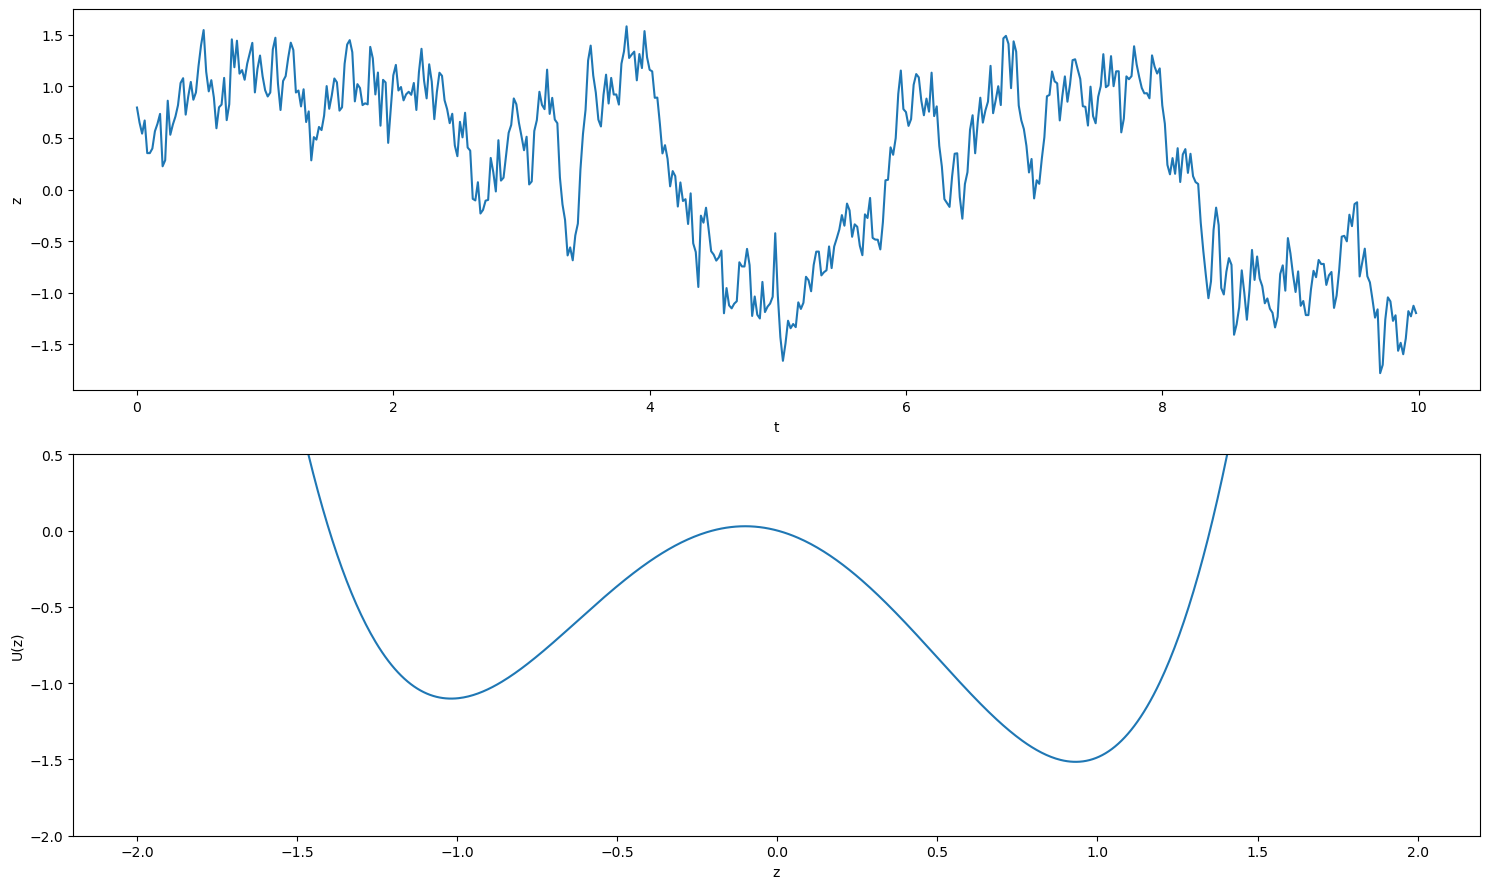

In [7]:
import random
import math

figure, ax = plt.subplots(2, 1, figsize=(15,9))

dT = 0.02
h = 0.001
L = int(dT/h)
t = np.arange(0, 10, dT)
n = len(t) 

z = 0.7

a = [0, -2,  0, 1, 0.1, 1.5]

p = a        

for i in range(1):
    y = [0] * n  
    random.seed(i)                     
    y[0] = z + random.gauss(0, p[4])    
    for k in range(1, n):
        for l in range(int(L)):
            z = z - h*(4 * p[3]*z**3 + 3*p[2]*z**2 + 2*p[1]*z + p[0]) + random.gauss(0, p[5] * np.sqrt(h))
        y[k] = z + random.gauss(0, p[4]) 
        
ax[0].plot(t, y)


xx = np.arange(-2, 2, 0.005)
def plot_potential(x, p):
    return (p[3]*x**4 + p[2]*x**3 + p[1]*x**2 + p[0]*x)

from pyDOE import *
from scipy.optimize import minimize

data = y

lo = np.array([-3,-3,-3,0,0.000001,0])
up = np.array([3,3,3,3,3,3])

set = lhs(len(lo), samples=1)                
set = lo + set.dot(np.diag(up - lo))

fit = minimize(ukf_1dim, [1,1,1,1,1,1], 0.001, method="L-BFGS-B", bounds=list(zip(lo, up)))

ax[1].plot(xx, plot_potential(xx, fit.x))
ax[1].set_ylim(-2,.5)

ax[0].set_ylabel("z")
ax[0].set_xlabel("t")
ax[1].set_ylabel("U(z)")
ax[1].set_xlabel("z")

plt.tight_layout()

plt.show()